In [123]:
lang = "en"
lang_data = "Es_data"

import json
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Flatten
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from tensorflow import keras

In [124]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Chargement des données

In [125]:
import os

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".train.json", "r") as file_handler:
    dataset = json.load(file_handler)

In [126]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".dev.json", "r") as file_handler:
    dataset_dev = json.load(file_handler)

In [127]:
sgns = [i['sgns'] for i in dataset]
glosses = [i['gloss'] for i in dataset]

In [128]:
sgns_dev = [i['sgns'] for i in dataset_dev]
glosses_dev = [i['gloss'] for i in dataset_dev]

In [129]:
print(len(glosses_dev))

6375


In [130]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemm2Idx_train.json") as outfile:
    lemm2Idx = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_idx2Lemm_train.json") as outfile:
    idx2Lemm = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemmatized_glosses_train.json") as outfile:
    lemmatized_glosses = json.load(outfile)

In [131]:
# Import DATA
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemm2Idx_dev.json") as outfile:
    lemm2Idx_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_idx2Lemm_dev.json") as outfile:
    idx2Lemm_dev = json.load(outfile)

with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +"_lemmatized_glosses_dev.json") as outfile:
    lemmatized_glosses_dev = json.load(outfile)

In [132]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Préparation des données

In [133]:
print(dataset[85]['gloss'])
print(dataset[253]['gloss'])

Periodismo.| Que pertenece o concierne al periódico .
Botánica.| ( Hypericum perforatum ) Planta arbustiva de flores amarillas con pequeñas motas negras en los bordes de los pétalos ; las hojas tiene bolsitas de aceite esencial que semejan perforaciones , al aplastarlas dejan una mancha de savia anaranjada . En medicina natural se usa para acelerar la cicatrización de las heridas .


In [134]:
lemmatized_glosses_text = []

for gloss in lemmatized_glosses:
    text = ""
    for word in gloss:
      try:
        text += idx2Lemm[str(word)] + " "
      except:
        print("An exception occurred : " + str(len(lemmatized_glosses_text)))
        
    lemmatized_glosses_text.append(text)

In [135]:
print(len(lemmatized_glosses_text))
print(len(sgns))


43608
43608


In [136]:
lemmatized_glosses_text_dev = []

for gloss in lemmatized_glosses_dev:
    text = ""
    for word in gloss:
        text += idx2Lemm_dev[str(word)] + " "
    lemmatized_glosses_text_dev.append(text)

In [137]:
print(len(lemmatized_glosses_text_dev))
print(len(sgns_dev))

6375
6375


In [138]:
def longest_gloss(glosses_list):
    lgt = 0
    sentence = ""
    tk = []
    for g in glosses_list :
        tokens = g.split()
        if len(tokens)>lgt :
            lgt = len(tokens)
            sentence =g
            tk = tokens
    return lgt

In [139]:
max_len = longest_gloss(lemmatized_glosses_text)
print(max_len)

228


In [140]:
max_len_dev = longest_gloss(lemmatized_glosses_text_dev)
print(max_len_dev)

142


In [141]:
max_tokens = len(list(lemm2Idx))
print(max_tokens)

max_tokens_dev = len(lemm2Idx_dev)

vectorize_layer = TextVectorization(
    # Max vocab size. Any words outside of the max_tokens most common ones
    # will be treated the same way: as "out of vocabulary" (OOV) tokens.
    max_tokens=max_tokens,
    # Output integer indices, one per string token
    output_mode="int",
    # Always pad or truncate to exactly this many tokens
    output_sequence_length=max_len
)

29383


In [142]:
# Call adapt(), which fits the TextVectorization layer to our text dataset.
# This is when the max_tokens most common words (i.e. the vocabulary) are selected.
vectorize_layer.adapt(np.array(list(idx2Lemm.values())))

In [143]:
print(np.array(list(idx2Lemm.values()))[10])

dos


### Construction du modèle

In [144]:
pip install tensorflow_addons

In [145]:
import tensorflow_addons as tfa
step = tf.Variable(0, trainable=False)
schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
    [10000, 15000], [1e-0, 1e-1, 1e-2])
# lr and wd can be a function or a tensor

lr = 1e-1 * schedule(step)

learning_rate=1e-3

wd = lambda: 1e-4 * schedule(step)

weight_decay=1e-6,

optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

In [146]:
import torch.optim as optim

opt = keras.optimizers.Adam(learning_rate=0.01)

In [147]:
model = Sequential()
model.add(Input(shape=(1,), dtype="string"))

In [148]:
model.add(vectorize_layer)

In [149]:
from tensorflow.keras import layers
# Note that we're using max_tokens + 1 here, since there's an
# out-of-vocabulary (OOV) token that gets added to the vocab.

len_gloses = 43608

model.add(Embedding(max_tokens + 1, 128))

model.add(Flatten())

model.add(Dense(256))

In [150]:
 model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 228)              0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 228, 128)          3761152   
                                                                 
 flatten_2 (Flatten)         (None, 29184)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               7471360   
                                                                 
Total params: 11,232,512
Trainable params: 11,232,512
Non-trainable params: 0
_________________________________________________________________


### Entraînement du modèle

In [151]:
with tf.device('/device:GPU:0'):
  history = model.fit(lemmatized_glosses_text, sgns,
                    epochs=20,
                    batch_size=192,
                    validation_data=(lemmatized_glosses_text_dev,  sgns_dev))

Epoch 1/20
228/228 [==============================] - 15s 64ms/step - loss: 0.9314 - accuracy: 0.0243 - val_loss: 0.9172 - val_accuracy: 0.0391
Epoch 2/20
228/228 [==============================] - 7s 29ms/step - loss: 0.8684 - accuracy: 0.0415 - val_loss: 0.9010 - val_accuracy: 0.0452
Epoch 3/20
228/228 [==============================] - 6s 25ms/step - loss: 0.8178 - accuracy: 0.0546 - val_loss: 0.9004 - val_accuracy: 0.0419
Epoch 4/20
228/228 [==============================] - 5s 23ms/step - loss: 0.7673 - accuracy: 0.0677 - val_loss: 0.9057 - val_accuracy: 0.0427
Epoch 5/20
228/228 [==============================] - 7s 30ms/step - loss: 0.7199 - accuracy: 0.0799 - val_loss: 0.9185 - val_accuracy: 0.0425
Epoch 6/20
228/228 [==============================] - 7s 32ms/step - loss: 0.6788 - accuracy: 0.0888 - val_loss: 0.9324 - val_accuracy: 0.0411
Epoch 7/20
228/228 [==============================] - 7s 29ms/step - loss: 0.6441 - accuracy: 0.1006 - val_loss: 0.9481 - val_accuracy: 0.039

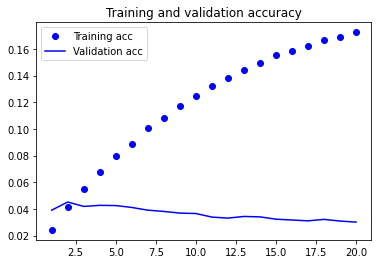

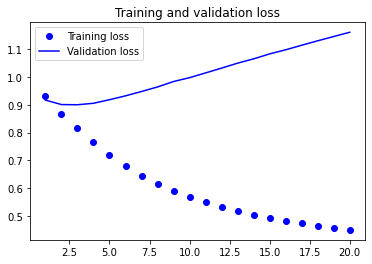

In [152]:
#Visualisation des résultats de l'entraînement.
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [153]:
#sauvegarde du modèle
model.save('_fr_revdict_model.tf')

INFO:tensorflow:Assets written to: _fr_revdict_model.tf/assets



### Test du modèle sur les données Trial

In [154]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".trial.complete.json", "r") as file_handler:
    dataset_trial = json.load(file_handler)

In [155]:
glosses_trial = []
for e in dataset_trial :
    glosses_trial.append(e["gloss"])

In [156]:
sgns_trial = []
for e in dataset_trial :
    sgns_trial.append(e["sgns"])

In [157]:
scores = model.evaluate(glosses_trial, sgns_trial, verbose=2)

7/7 - 0s - loss: 1.1396 - accuracy: 0.0300 - 64ms/epoch - 9ms/step


In [158]:
classes_trial = model.predict(glosses_trial, batch_size=32)

In [159]:
print(len(classes_trial))

200


In [160]:
print(len(classes_trial[0]))

256


In [161]:
results = []

prefix_id = "fr.revdict."
i = 0
for g in glosses_trial :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_trial[glosses_trial.index(g)]
  results.append(sample)
  i+=1

print("taille du resultat : ", len(results))
# affichage du premier vecteur pour visualiser les résultats produits
print("vecteur trial ---> prédiction")
for v in sgns_trial[0] :
  print(v, " ---> ", results[0]["sgns"][list(sgns_trial[0]).index(v)])

taille du resultat :  200
vecteur trial ---> prédiction
0.1575131714  --->  0.6597133
0.0189403091  --->  0.09415172
0.047191631  --->  0.51982605
0.0707909912  --->  -0.12769519
0.007075524  --->  -0.43499348
0.2173704058  --->  0.13880834
-0.302382648  --->  0.13575897
0.0303572901  --->  -0.35664755
-0.1786215454  --->  -0.31907883
-0.2511086166  --->  0.12496126
0.0213172324  --->  -0.21318515
-0.0064525362  --->  -0.10636602
0.1377538592  --->  0.23142192
-0.029804673  --->  -0.40713674
0.1349020749  --->  0.11290096
0.0029863075  --->  -0.109426126
0.2212906033  --->  0.08825454
-0.3678811193  --->  -0.23267445
0.0743748695  --->  -0.79231966
-0.059776932  --->  0.5312316
0.0471581072  --->  -0.06116011
0.1289159507  --->  -0.6288775
-0.1273846775  --->  0.14939228
0.0445760638  --->  -0.120149635
0.0737065002  --->  0.051744357
0.1829497218  --->  -0.034996916
-0.1597850919  --->  -0.4471898
0.1143697649  --->  0.059821963
-0.1252015382  --->  -0.0042650998
0.0370162427  --->  0

In [162]:
import pandas as pd
pd.Series(results).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_trial.json", orient='values')

### Calcule des métriques d'évaluation

In [163]:
import torch.nn.functional as F
import torch

classes_trial_tensor = torch.tensor(classes_trial)
sgns_trial_tensor = torch.tensor(sgns_trial)

In [164]:
cos_sim = F.cosine_similarity(classes_trial_tensor, sgns_trial_tensor).mean().item()

In [165]:
print(cos_sim)

0.2613191604614258


In [166]:
mse = F.mse_loss(classes_trial_tensor, sgns_trial_tensor).item()

In [167]:
print(mse)

1.1395894289016724


In [168]:
# fonction prise du code de la baseline.
def rank_cosine(preds, targets):
    unique_targets = targets.unique(dim=0)
    all_assocs = preds @ F.normalize(targets).T
    unique_assocs = preds @ F.normalize(unique_targets).T
    refs = torch.diagonal(all_assocs, 0).unsqueeze(1)
    ranks = (unique_assocs >= refs).sum(1).float().mean().item()
    return ranks / unique_targets.size(0)

In [169]:
rnk = rank_cosine(classes_trial_tensor, sgns_trial_tensor)

In [170]:
print(rnk)

0.24717171023590395


### Test du modèle sur les données de DEV


In [171]:
scores = model.evaluate(glosses_dev, sgns_dev, verbose=2)

200/200 - 1s - loss: 1.1380 - accuracy: 0.0260 - 790ms/epoch - 4ms/step


In [172]:
classes_dev = model.predict(glosses_dev, batch_size=32)

In [173]:
print(len(classes_dev))

6375


In [174]:
print(len(classes_dev[0]))

256


In [175]:
results_dev = []

prefix_id = "fr.revdict."
i = 0
for g in glosses_dev :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_dev[glosses_dev.index(g)]
  results_dev.append(sample)
  i+=1

print("taille du résultat : ", len(results_dev))
print("vecteur dev ---> prédiction")
for v in sgns_dev[0] :
  print(v, " ---> ", results_dev[0]["sgns"][list(sgns_dev[0]).index(v)])

taille du résultat :  6375
vecteur dev ---> prédiction
-0.0948127583  --->  0.23488896
0.0695908368  --->  -0.0026637912
0.1231811196  --->  -0.1617604
0.0118940957  --->  0.0041902587
-0.2113233656  --->  -1.2544028
-0.1692465693  --->  0.03269612
0.2417917699  --->  -0.42844227
0.1362679452  --->  0.46545544
0.0448402762  --->  -0.29194462
-0.1217409  --->  0.23838872
0.5192964673  --->  0.015443312
-0.1261774898  --->  0.44781137
0.13966012  --->  0.6181851
0.1047851369  --->  0.4126487
0.0183477774  --->  0.07941946
-0.1120414585  --->  0.60453594
0.0355071016  --->  0.3220439
-0.3026729226  --->  -0.20377763
-0.2326734513  --->  -0.99809927
-0.3383509815  --->  0.58195543
0.0853335336  --->  -0.8109026
0.2102634907  --->  -0.56877756
-0.1169508696  --->  -0.27145323
-0.0368832685  --->  0.10465563
-0.2963701189  --->  0.010529414
-0.1813153476  --->  -0.12159602
0.1627516448  --->  -0.35524756
0.0034966767  --->  -0.52067196
-0.1050161347  --->  0.8115042
0.096976459  --->  0.8341

In [176]:
import pandas as pd
pd.Series(results_dev).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_dev.json", orient='values')


### Test du modèle sur les données de TEST

In [177]:
with open("/content/drive/My Drive/Datasets/Data_semEval2022/"+ lang_data +"/"+ lang +".test.revdict.json", "r") as file_handler:
    dataset_test = json.load(file_handler)

In [178]:
glosses_test = []
for e in dataset_test :
    glosses_test.append(e["gloss"])

In [179]:
classes_test = model.predict(glosses_test, batch_size=32)

In [180]:
print(len(classes_test))

6208


In [181]:
print(len(classes_test[0]))

256


In [182]:
results_test = []

prefix_id = lang+".revdict."
i = 1
for g in glosses_test :
  sample = {}
  id = prefix_id + str(i)
  sample["id"] = id
  sample["gloss"] = g
  sample["sgns"] = classes_test[glosses_test.index(g)]
  results_test.append(sample)
  i+=1

print("taille du resultat : ", len(results_test))

taille du resultat :  6208


In [183]:
import pandas as pd
pd.Series(results_test).to_json("/content/drive/My Drive/Datasets/Data_semEval2022/Results/sgns/"+lang+"_revdict_results_prediction_test.json", orient='values')